### Laboratorium 6 - zadania

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

#### Zadanie 1 (1.5 pkt | 1.0 pkt)

Dany jest obraz `road`. Wykorzystaj transformatę Hougha do detekcji linii, aby wykryć pas jezdni. Wykorzystaj ulubiony detektor krawędzi i zaprezentuj wyniki pośrednie przed użyciem transformaty Hougha. Zapoznaj się z dokumentacją funkcji [`cv2.HoughLines`](https://docs.opencv.org/4.5.3/dd/d1a/group__imgproc__feature.html#ga46b4e588934f6c8dfd509cc6e0e4545a), zwłaszcza parametrami sterującymi rozdzielczością `rho`, `theta` oraz progiem `threshold` i przeanalizuj ich wpływ na osiągane wyniki.  
Nie skupiaj się na parametrach detektora krawędzi - znajdź odpowiednie i tych się trzymaj.  
Ostateczny rezultat zaprezentuj w postaci linii naniesionych na kopię obrazu wejściowego.

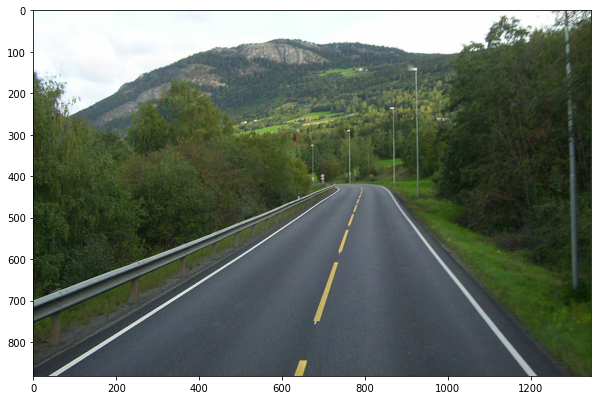

In [2]:
road = cv2.imread('Road_in_Norway.jpg')
plt.imshow(cv2.cvtColor(road, cv2.COLOR_BGR2RGB));
plt.gcf().set_figwidth(10)
plt.gcf().set_figheight(10)

In [3]:
def rhotheta2xy(line):
    # to samo co w przykładzie tylko w formie funkcji - na potrzeby rysowania
    # zwraca współrzędne odcinka leżącego na pojedynczej linii
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 5000*(-b))
    y1 = int(y0 + 5000*(a))
    x2 = int(x0 - 5000*(-b))
    y2 = int(y0 - 5000*(a))
    return x1, y1, x2, y2

Rozwiązanie:

In [50]:
def zad1(img, t1=300, t2=500, ro=3, theta=20, thresh=170):
    img_Gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kr_Canny = cv2.Canny(image=img_Gray, threshold1=t1, threshold2=t2)
    
    fig, ax = plt.subplots(1,2, figsize=(20,10))
    ax[0].imshow(kr_Canny, cmap='gray')
    ax[0].axis('off')
    ax[0].set_title(f'After Canny  t1: {t1}  t2: {t2}', fontsize=15)
    
    lines = cv2.HoughLines(kr_Canny, ro, theta*np.pi/180, thresh)
    
    image_lines = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).copy()
    for line in lines:
        x1, y1, x2, y2 = rhotheta2xy(line)
        cv2.line(image_lines, (x1,y1), (x2,y2), (255,0,0), 2)
    
    ax[1].imshow(image_lines)
    ax[1].axis('off')
    ax[1].set_title(f'Detected lines with Hough.\nParams : ro - {ro}, theta - {theta} * pi/180, threshold - {thresh}', fontsize=15)

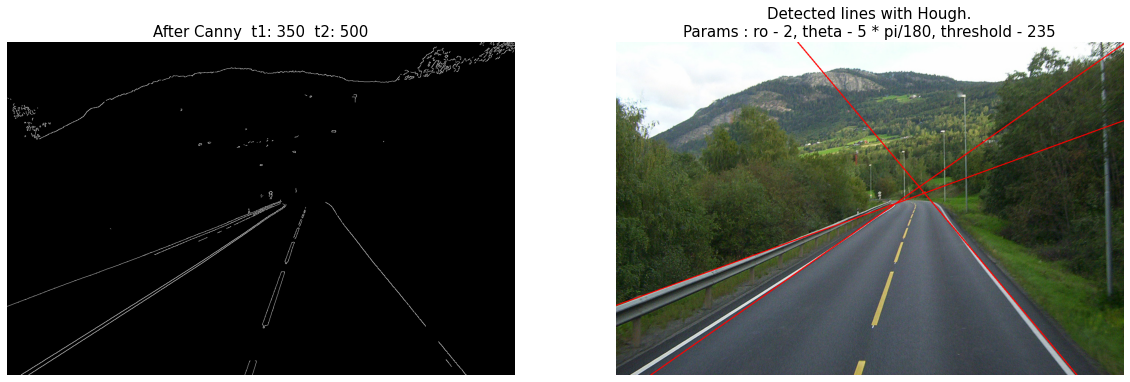

In [52]:
zad1(road,t1=350, t2=500,ro=2, theta=5, thresh=235)
plt.savefig("zad1v1.png")

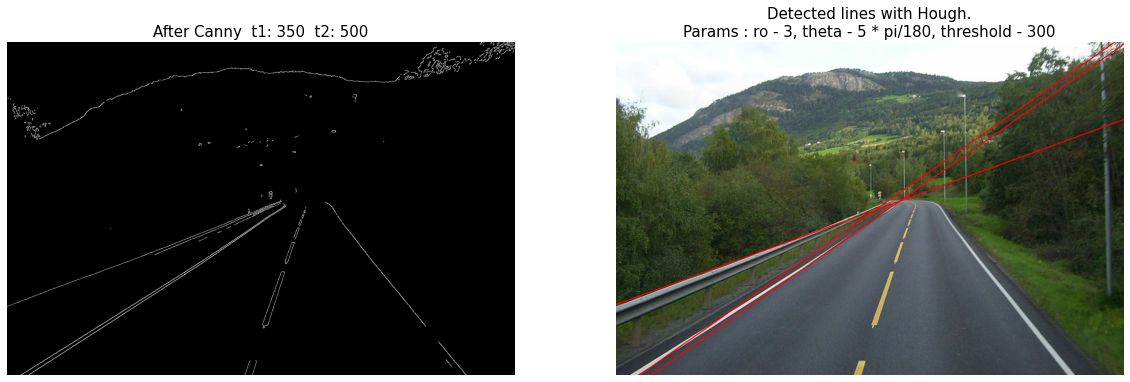

In [58]:
zad1(road,t1=350, t2=500, ro=3, theta=5, thresh=300)

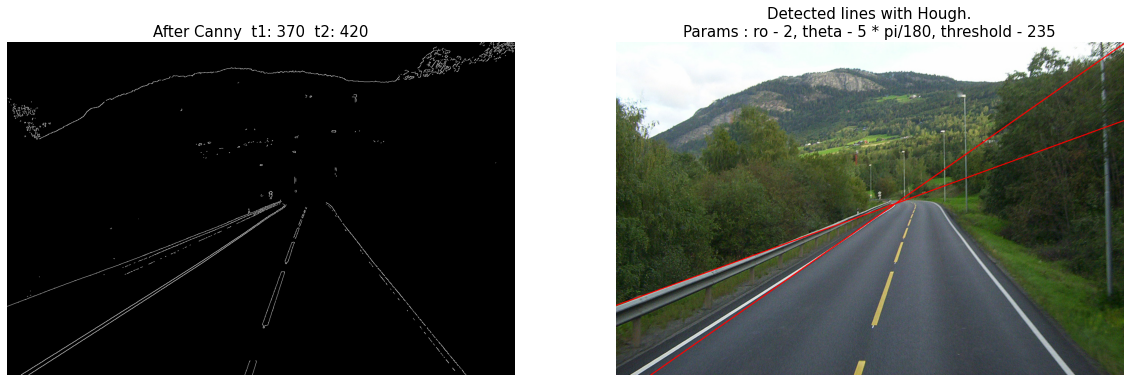

In [64]:
zad1(road,t1=370, t2=420,ro=2, theta=5, thresh=235)

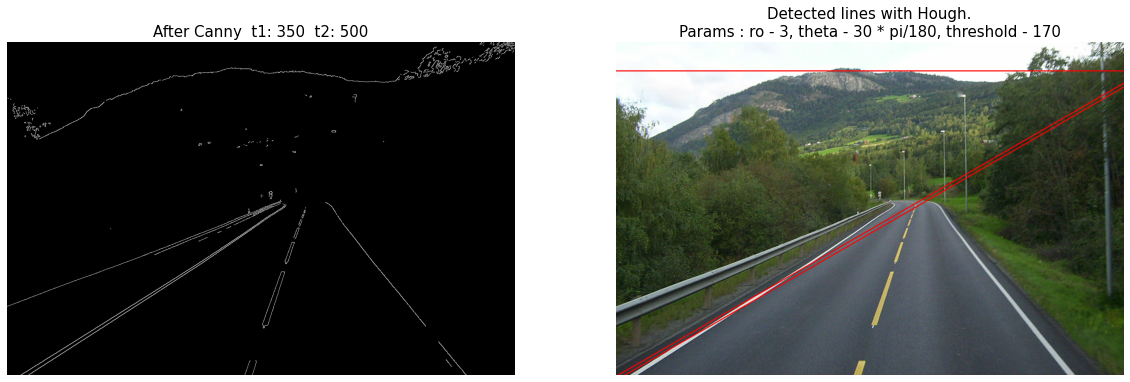

In [65]:
zad1(road,t1=350, t2=500, theta=30)

#### Zadanie 2 (1.5 pkt | 1.0 pkt)

Dany jest obraz `coins`. Celem jest (1) przebadanie wpływu parametrów funkcji [`cv2.HoughCircles`](https://docs.opencv.org/4.5.3/dd/d1a/group__imgproc__feature.html#ga47849c3be0d0406ad3ca45db65a25d2d) na znajdowane okręgi oraz (2) wykorzystanie transformaty Hougha do zliczenia monet znajdujących się na obrazie. Jak poprzednio, zacznij od uzyskania dobrej jakości detekcji krawędzi - natychmiast zauważysz, że im więcej na obrazie zakłóceń (tj. krawędzi nie będących interesującymi nas okręgami), tym gorsze będą rezultaty transformacji Hougha.  
Aby wyznaczyć sensowne wartości początkowe parametrów `HoughCircles`, przyjrzyj się geometrii obrazu - "na oko" przyjmij wartości `minDist`, `minRadius` i `maxRadius`; wybierz metodę `cv2.HOUGH_GRADIENT`, załóż $dp=1.5$ i przy tych wartościach znajdź wartość `param2`. Jeśli twój detektor krawędzi działa dobrze, parametr `param1` możesz wtedy pominąć.

Zwróć uwagę, że `cv2.HoughCircles` zwraca wynik w postaci zmiennoprzecinkowej `np.ndarray` o 3 wymiarach: (1, N, 3) gdzie N to liczba wykrytych okręgów a trójka liczb w ostatnim wymiarze odpowiada parametrom *x, y, r* wykrytego okręgu.

Zaprezentuj ostateczny wynik tak jak w zadaniu 1; do narysowania okręgów wykorzystaj funkcję [`cv2.circle`](https://docs.opencv.org/4.5.3/d6/d6e/group__imgproc__draw.html#gaf10604b069374903dbd0f0488cb43670) (pamiętaj, że oczekuje parametrów okręgu jako liczby całkowite!).

---

*Jeśli starczy czasu*: wykorzystując wykryte okręgi do dalszego przetwarzania obrazu, odróżnij monety srebrne od brązowych (policz jedne i drugie, zaznacz okręgami o różnych kolorach na obrazie).

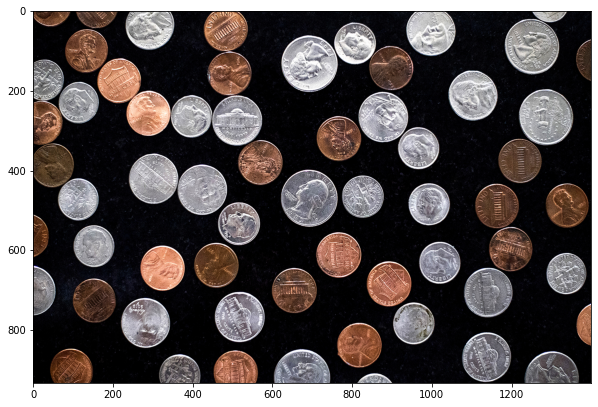

In [66]:
coins = cv2.imread('Coins.jpg')
plt.imshow(coins[..., ::-1]);
plt.gcf().set_figwidth(10)
plt.gcf().set_figheight(10)

Rozwiązanie:

In [91]:
from sklearn.preprocessing import StandardScaler
import math

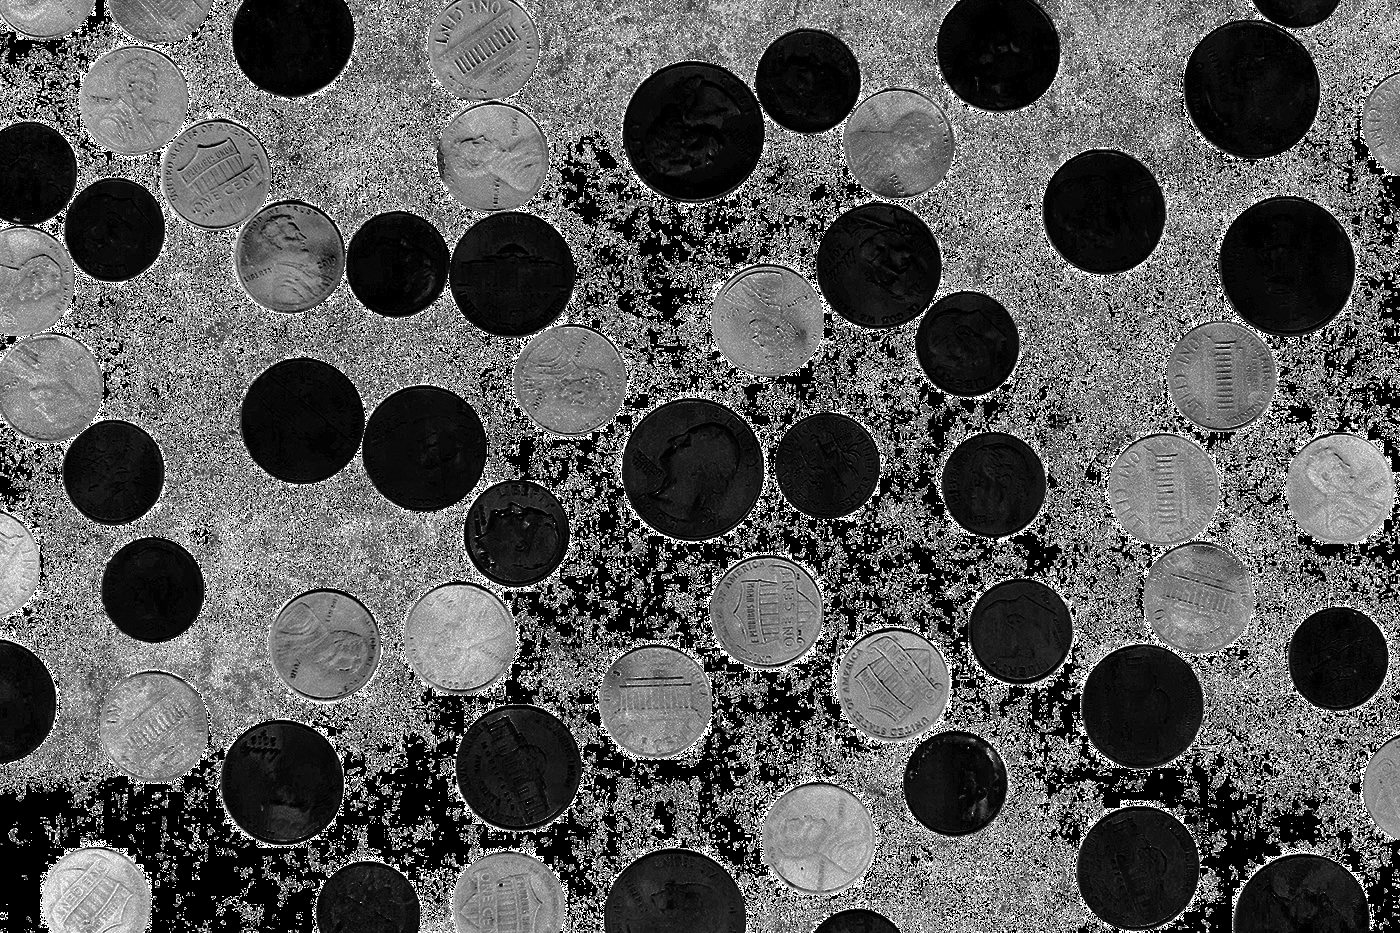

In [117]:
Image.fromarray(cv2.cvtColor(coins, cv2.COLOR_BGR2HSV)[:,:,1])

In [142]:

def filter_gauss(img, kernel_size):
    filtered_img = cv2.GaussianBlur(img,(kernel_size, kernel_size),cv2.BORDER_DEFAULT)
    return filtered_img

def zad2(img, t1=300, t2=300, thresh_low=50, thresh_up=120, param2=50, param1=100,use_masking=False):
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    
    img_filtered = filter_gauss(img_hsv, 5)
    
    (T, monety_thresh) = cv2.threshold(img_filtered[:,:,2], thresh_low, thresh_up, cv2.THRESH_BINARY)
    
    kr_Canny = cv2.Canny(image=monety_thresh, threshold1=t1, threshold2=t2)
    
    fig, ax = plt.subplots(1,3, figsize=(30,10))
#     ax[0].imshow(img_filtered[:,:,2], cmap='gray')
#     ax[0].imshow(monety_thresh, cmap='gray')
    ax[0].imshow(kr_Canny, cmap='gray')
    ax[0].axis('off')
    ax[0].set_title(f'After Canny  t1 {t1}  t2 {t2}',fontsize=16)
    
    
    circles = cv2.HoughCircles(kr_Canny, cv2.HOUGH_GRADIENT, dp=1.5, minDist=40, minRadius=20, maxRadius=150, param2=param2, param1=param1)
    
    
    image_lines = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).copy()
    
    circle_features = []
    for circle in circles[0].astype(int):
        x, y, r = circle
        
        cv2.circle(image_lines, (x,y), r, (255,0,0), 5)
        r_half = math.ceil(r/2)
        slice_img =img_hsv[y-r_half:y+r_half, x-r_half:x+r_half, :]
        
        slice_img_R = slice_img[:,:,0]
        slice_img_G = slice_img[:,:,1]
        slice_img_B= slice_img[:,:,2]
        circle_features.append([np.mean(slice_img_G)])
            
    circle_features = np.float32(circle_features)
    scaler = StandardScaler()
    segments_array = scaler.fit_transform(circle_features)
    
    c, labels, centers = cv2.kmeans(
        data=segments_array,
        K=2,
        bestLabels=None,
        criteria=(cv2.TERM_CRITERIA_EPS, 10, 1.0),
        attempts=20,
        flags=cv2.KMEANS_RANDOM_CENTERS
    )
    
#     segment_lines = np.zeros_like(image_lines)
    segment_lines = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).copy()
    for i, circle in enumerate(circles[0].astype(int)):
        x, y, r = circle
        color = (255,0,0) if labels[i] == 0 else (0,255,0)
#         color = (255,0,0) if circle_features[i] > 150 else (0, 255, 0)
        cv2.circle(segment_lines, (x,y), r, color, -1)
        
    
    ax[1].imshow(image_lines)
    ax[1].axis('off')
    ax[1].set_title('Hough', fontsize=16)
    ax[2].imshow(segment_lines)
    ax[2].axis('off')
    ax[2].set_title('Segmentation', fontsize=16)
    
    
    

    filtered_img = cv2.GaussianBlur(img,(kernel_size, kernel_size),cv2.BORDER_DEFAULT)
    return filtered_img

def zad2v2(img, t1=300, t2=300, thresh_low=50, thresh_up=120, param2=50, param1=100,use_masking=False):
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    
    img_filtered = filter_gauss(img_hsv, 5)
    
    (T, monety_thresh) = cv2.threshold(img_filtered[:,:,2], thresh_low, thresh_up, cv2.THRESH_BINARY)
    
    kr_Canny = cv2.Canny(image=monety_thresh, threshold1=t1, threshold2=t2)
    
    fig, ax = plt.subplots(1,2, figsize=(30,10))
#     ax[0].imshow(img_filtered[:,:,2], cmap='gray')
#     ax[0].imshow(monety_thresh, cmap='gray')
    ax[0].imshow(kr_Canny, cmap='gray')
    ax[0].axis('off')
    ax[0].set_title(f'After Canny  t1 {t1}  t2 {t2}',fontsize=16)
    
    
    circles = cv2.HoughCircles(kr_Canny, cv2.HOUGH_GRADIENT, dp=1.5, minDist=40, minRadius=20, maxRadius=150, param2=param2, param1=param1)
    
    
    image_lines = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).copy()
    
    circle_features = []
    for circle in circles[0].astype(int):
        x, y, r = circle
        
        cv2.circle(image_lines, (x,y), r, (255,0,0), 5)
       
    
    ax[1].imshow(image_lines)
    ax[1].axis('off')
    ax[1].set_title('Hough', fontsize=16)

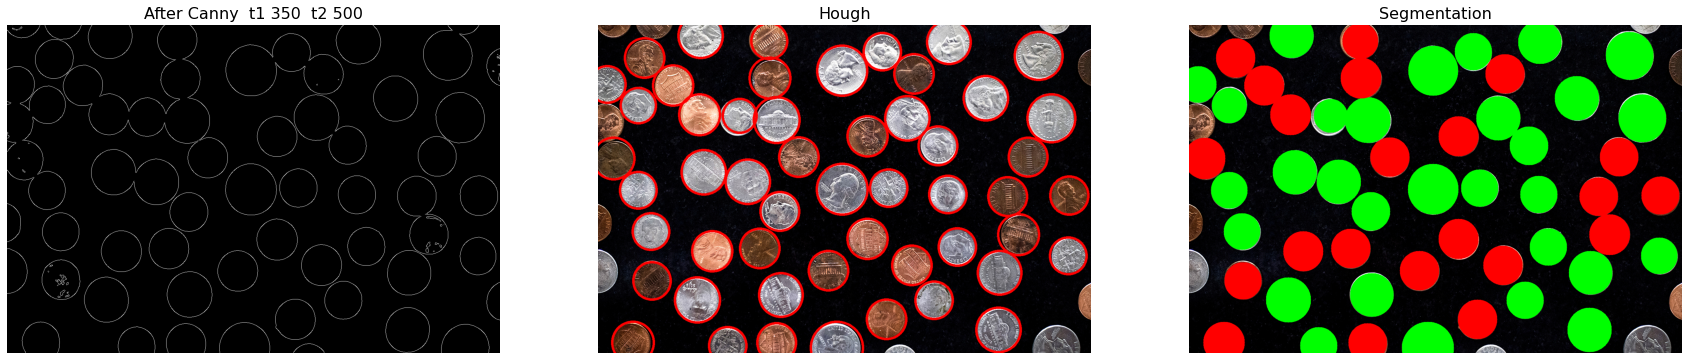

In [141]:
zad2(coins, t1=350, t2=500,thresh_low=50, param2=50)
plt.savefig('zad2v1.png')

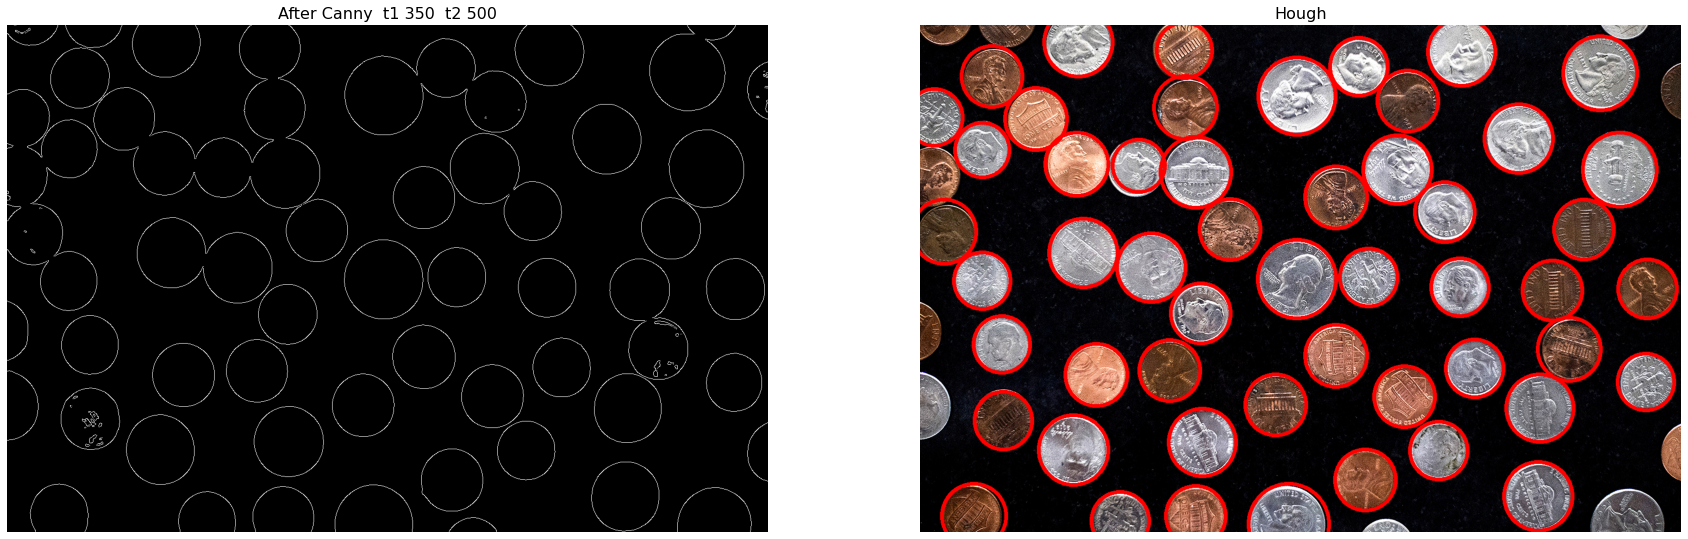

In [146]:
zad2v2(coins, t1=350, t2=500,thresh_low=50, param2=50)
plt.savefig("zad2v2.png")

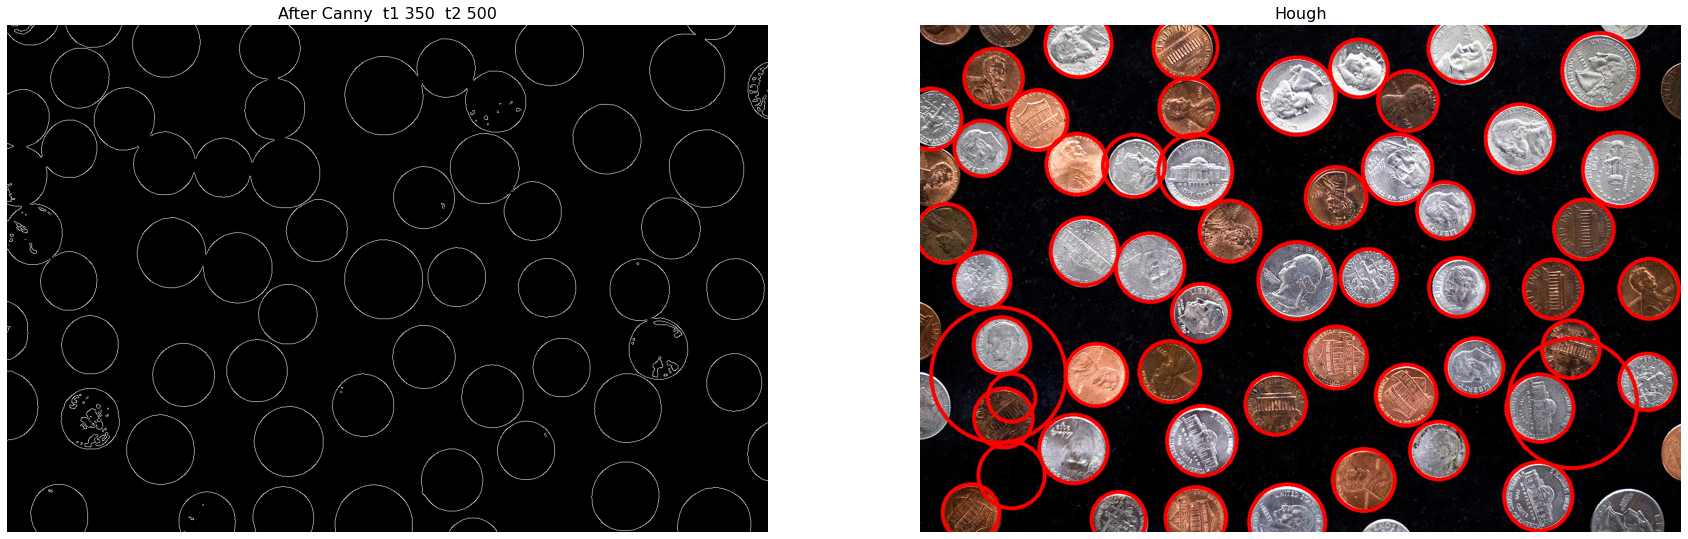

In [147]:
zad2v2(coins, t1=350, t2=500,thresh_low=60, param2=50)
plt.savefig("zad2v3.png")

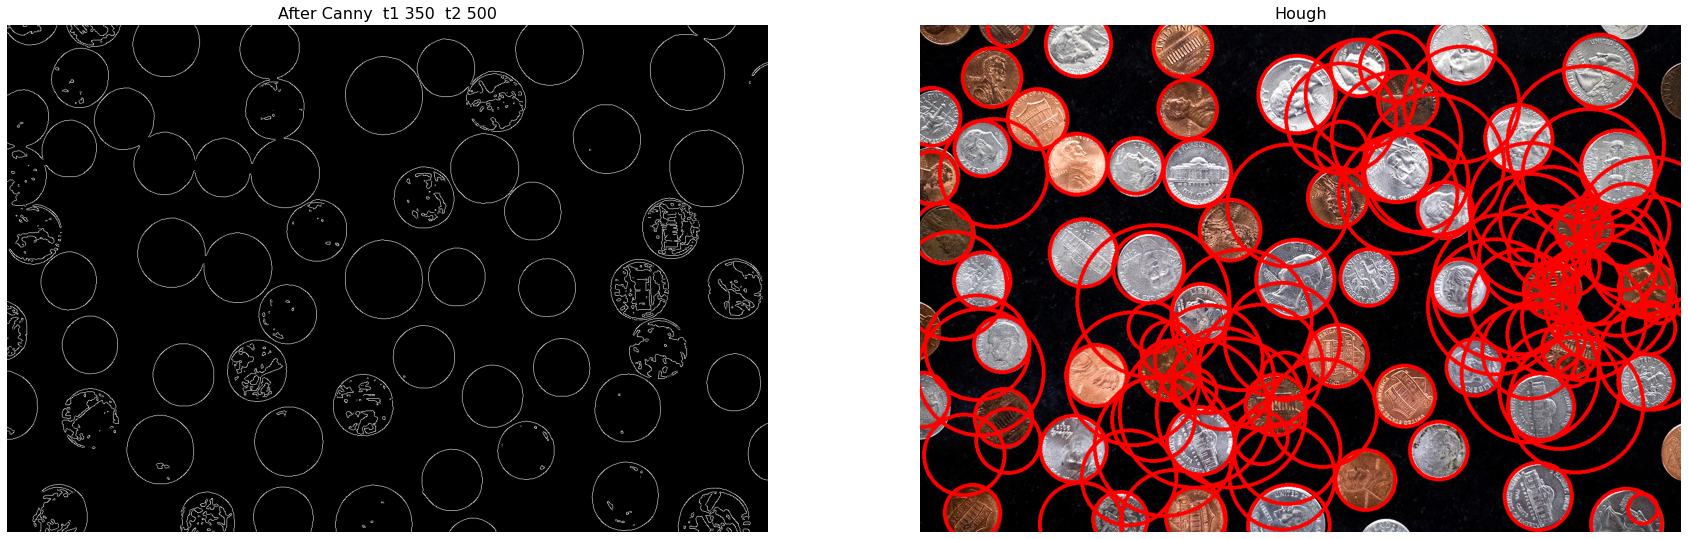

In [148]:
zad2v2(coins, t1=350, t2=500,thresh_low=90,thresh_up=120, param2=50)
plt.savefig("zad2v4.png")